# Group Names:
- Moustafa Essameldin Moustafa Ibrahim
- Mostafa Mohamed Ibrahim Abdelrady
- Osama Mohamed Abass Mohamed
- Ahmed Osama Mohammed  Abd_Alkader

# Upload Data

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d shreyapmaher/fruits-dataset-images

Dataset URL: https://www.kaggle.com/datasets/shreyapmaher/fruits-dataset-images
License(s): other
 89% 183M/205M [00:00<00:00, 239MB/s]
100% 205M/205M [00:00<00:00, 227MB/s]


In [ ]:
!unzip -q /content/fruits-dataset-images.zip -d /content/

# Libraries Needed

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing import image
from PIL import Image, ImageDraw, ImageFont
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, optimizers, models
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout

# Loading Data

In [ ]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        fruit_folder = os.path.join(folder, label)
        if os.path.isdir(fruit_folder):
            for filename in os.listdir(fruit_folder):
                img_path = os.path.join(fruit_folder, filename)
                try:
                    img = Image.open(img_path)
                    images.append(img)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    return images, labels

# Load images and labels
dataset_path = '/content/images'
images, labels = load_images_from_folder(dataset_path)

# Verify data
print(f"Number of images loaded: {len(images)}")
print(f"Number of labels loaded: {len(labels)}")
print(f"Sample labels: {labels[:5]}")
print(f"Sample images (type): {[type(img) for img in images[:5]]}")

Number of images loaded: 360
Number of labels loaded: 360
Sample labels: ['strawberry fruit', 'strawberry fruit', 'strawberry fruit', 'strawberry fruit', 'strawberry fruit']
Sample images (type): [<class 'PIL.JpegImagePlugin.JpegImageFile'>, <class 'PIL.JpegImagePlugin.JpegImageFile'>, <class 'PIL.JpegImagePlugin.JpegImageFile'>, <class 'PIL.JpegImagePlugin.JpegImageFile'>, <class 'PIL.JpegImagePlugin.JpegImageFile'>]


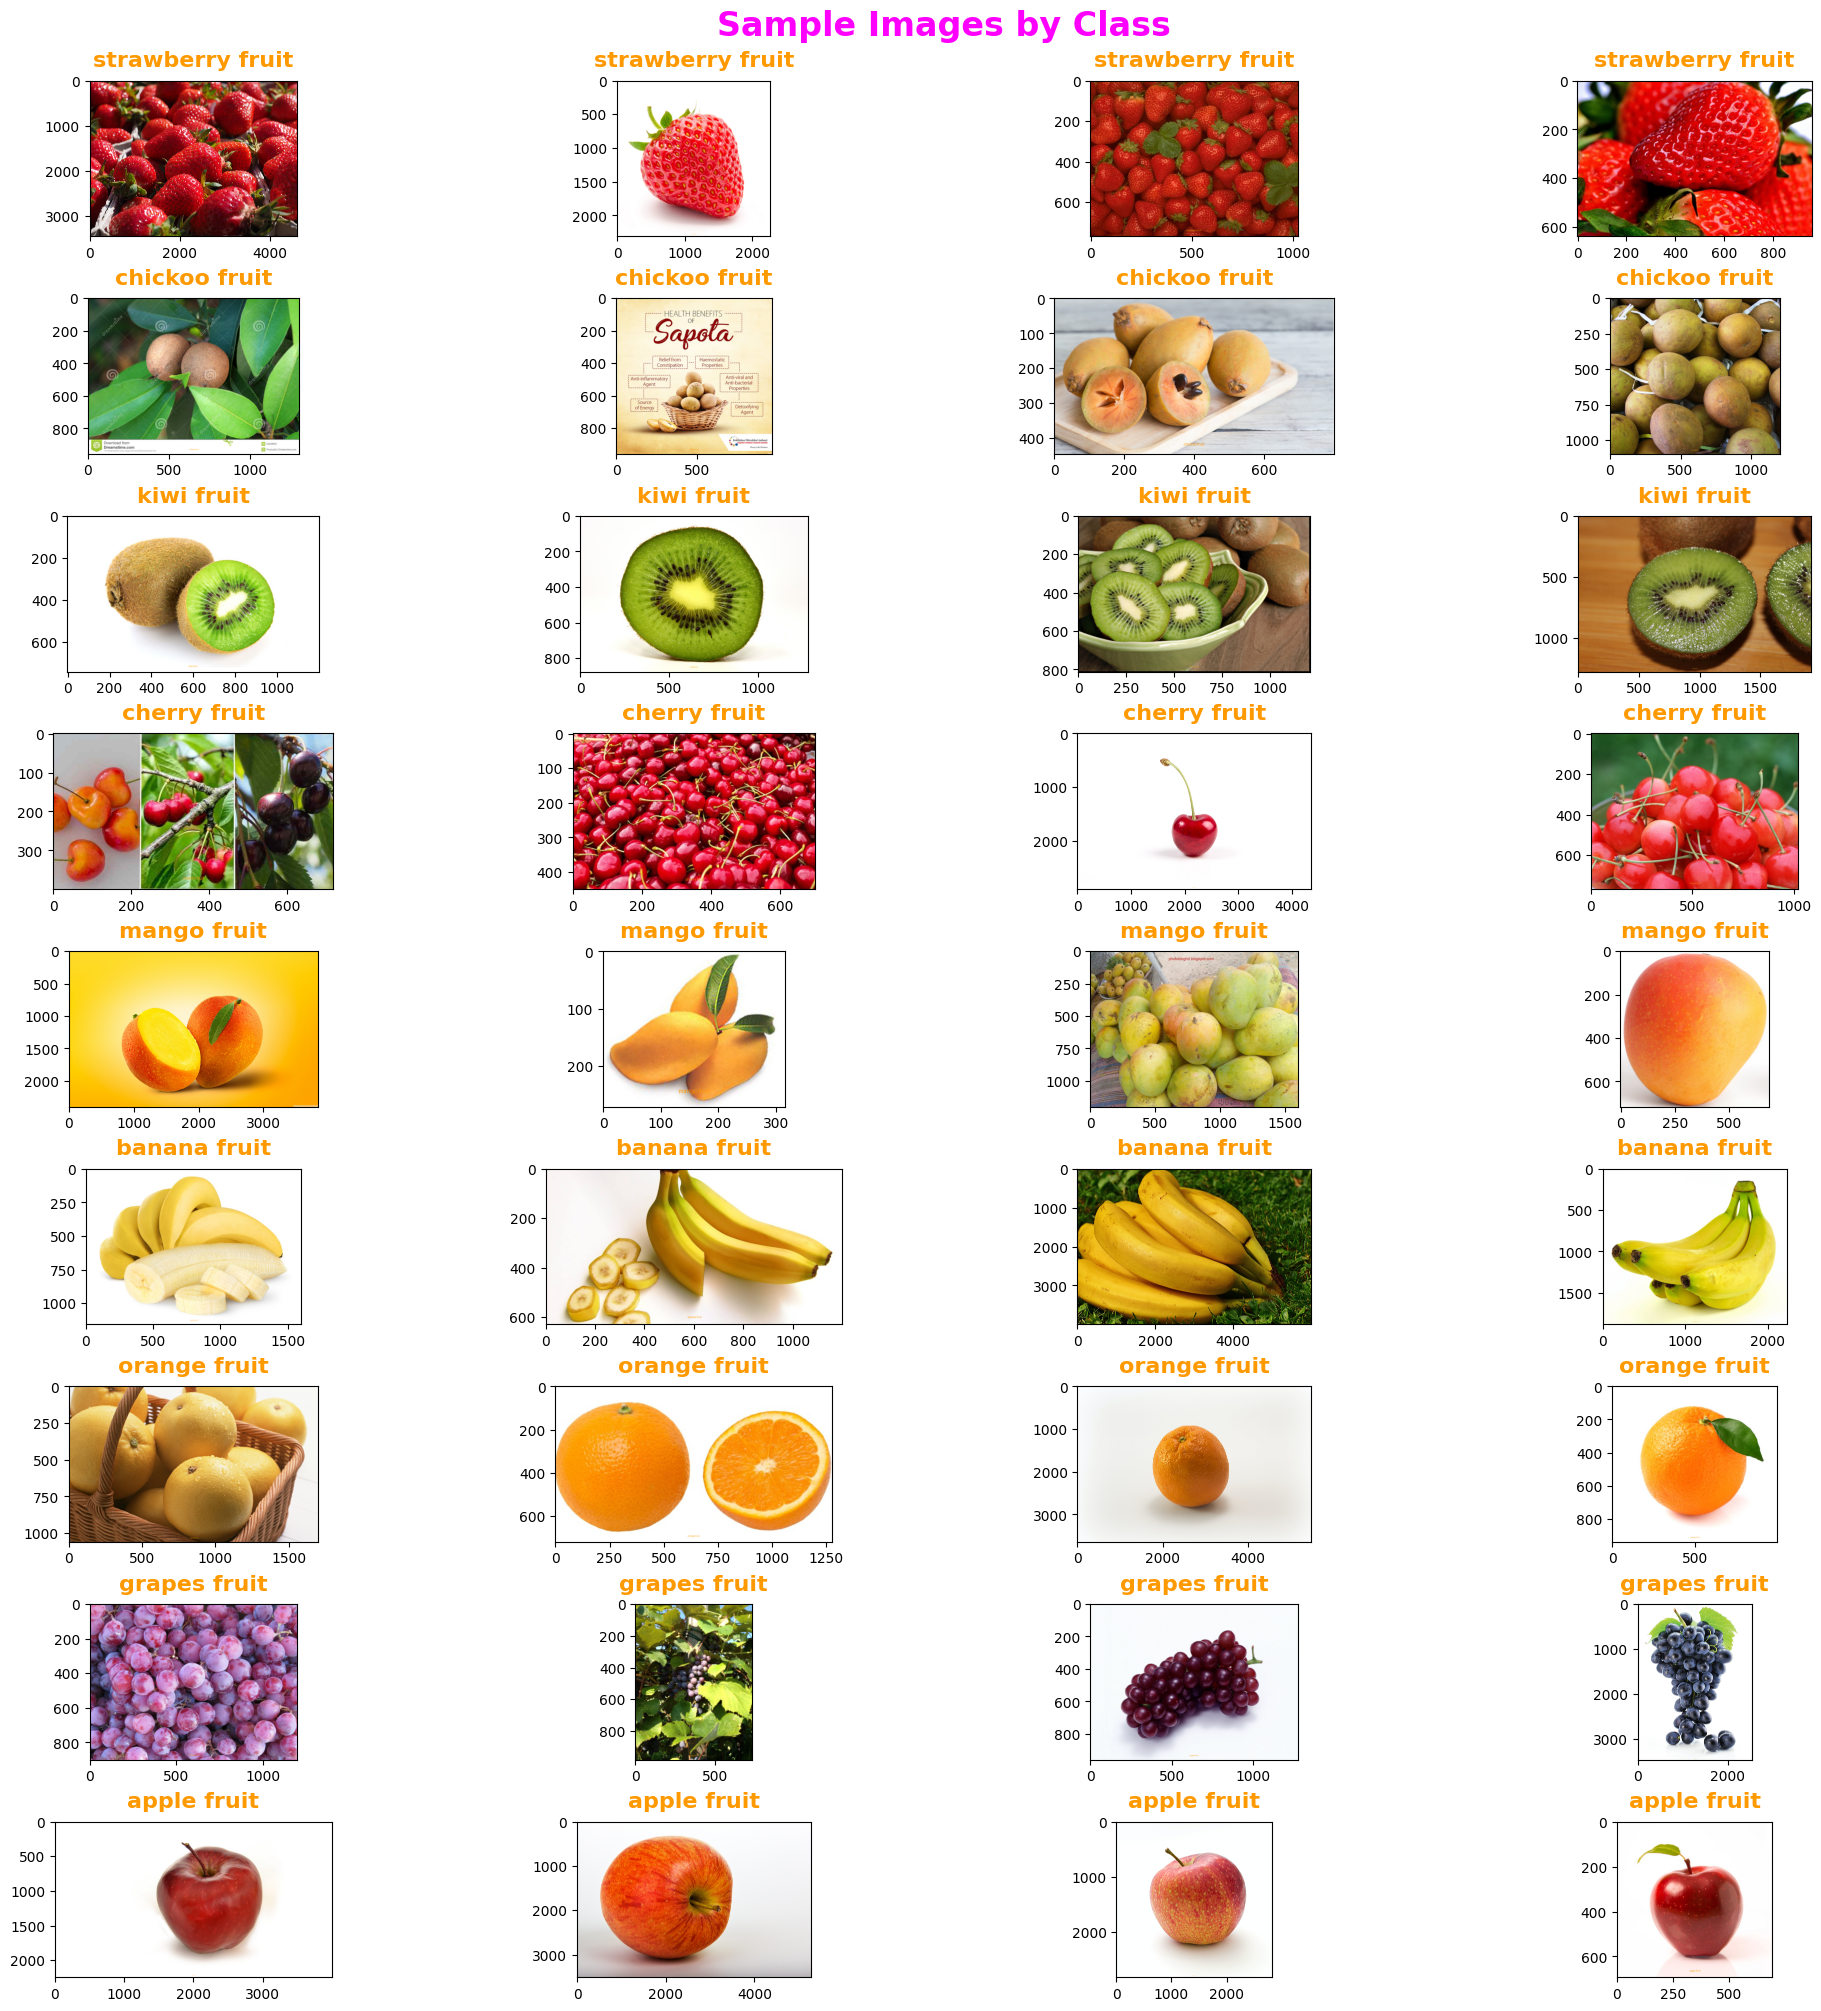

In [ ]:
def create_image_with_background(image, title, background_color=(15, 15, 15), text_color=(255, 153, 0), font_size=24):
    # Ensure the image is in RGB mode
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Create a new image with a background color
    new_image = Image.new('RGB', image.size, background_color)
    new_image.paste(image, (0, 0))

    # Add title text
    draw = ImageDraw.Draw(new_image)
    try:
        # Load a truetype or opentype font file, replacing with a default font if not available
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()
        text_width = draw.textlength(title, font=font)
        text_height = font_size
    else:
        text_width, text_height = draw.textsize(title, font=font)
    position = ((new_image.width - text_width) / 2, new_image.height - text_height - 10)  # Center the text horizontally
    draw.text(position, title, text_color, font=font)

    return new_image

def show_images_per_class(images, labels, num_per_class=4):
    # Organize images by class
    class_images = {}
    for img, label in zip(images, labels):
        if label not in class_images:
            class_images[label] = []
        class_images[label].append(img)

    # Create a plot with more sophisticated styling
    num_classes = len(class_images)
    fig, axes = plt.subplots(num_classes, num_per_class, figsize=(20, 20), constrained_layout=True)
    for idx, (label, imgs) in enumerate(class_images.items()):
        for jdx in range(num_per_class):
            ax = axes[idx, jdx]
            if jdx < len(imgs):
                img_with_bg = create_image_with_background(imgs[jdx], label)
                # Convert PIL image to numpy array for imshow
                ax.imshow(np.array(img_with_bg))
                ax.set_title(f'{label}', fontsize=16, pad=10, color='#ff9900', fontweight='bold')
            else:
                ax.axis('off')  # Hide empty subplots

    plt.suptitle('Sample Images by Class', fontsize=24, fontweight='bold', color='#ff00ff', fontfamily='Orbitron')
    plt.show()
def load_sample_images(image_folder, num_samples=5):
    sample_images = []
    sample_labels = []

    for label in os.listdir(image_folder):
        class_folder = os.path.join(image_folder, label)
        for image_name in os.listdir(class_folder)[:num_samples]:
            img_path = os.path.join(class_folder, image_name)
            img = Image.open(img_path)
            sample_images.append(img)
            sample_labels.append(label)

    return sample_images, sample_labels


image_folder_path = '/content/images'
images, labels = load_sample_images(image_folder_path)


show_images_per_class(images, labels)

In [ ]:
import shutil
from sklearn.model_selection import train_test_split

source_folder = '/content/images'  # Main folder with subfolders of classes
train_folder = '/content/Train_Folder2'    # Folder where training images will go
test_folder = '/content/Test_Folder2'      # Folder where testing images will go

# Create train and test folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Loop through each class folder
for class_name in os.listdir(source_folder):
    class_path = os.path.join(source_folder, class_name)

    if os.path.isdir(class_path):
        # List all image files in the class folder
        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        # Split the image files into train and test sets
        train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)

        # Create class directories in the train and test folders
        class_train_folder = os.path.join(train_folder, class_name)
        class_test_folder = os.path.join(test_folder, class_name)

        os.makedirs(class_train_folder, exist_ok=True)
        os.makedirs(class_test_folder, exist_ok=True)

        # Move training files
        for file_name in train_files:
            shutil.move(os.path.join(class_path, file_name), os.path.join(class_train_folder, file_name))

        # Move testing files
        for file_name in test_files:
            shutil.move(os.path.join(class_path, file_name), os.path.join(class_test_folder, file_name))

In [ ]:
train_dir = '/content/Train_Folder2'
test_dir = '/content/Test_Folder2'

# Define image data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Rescale pixel values from [0,255] to [0,1]
    shear_range=0.2,         # Random shear for augmentation
    zoom_range=0.2,          # Random zoom for augmentation
    horizontal_flip=True,    # Flip the image horizontally
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from the directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # AlexNet expects 227x227 images
    batch_size=32,
    class_mode='categorical' # Use categorical if you have multiple classes
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 287 images belonging to 9 classes.
Found 72 images belonging to 9 classes.


# CNN Model

In [ ]:
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',  input_shape=(224, 224, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(128, activation='relu'))
cnn_model.add(layers.Dense(9, activation='softmax'))

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1376 - loss: 2.6913 - val_accuracy: 0.3906 - val_loss: 1.9115
Epoch 2/20
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3438 - loss: 1.9970

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - accuracy: 0.3438 - loss: 1.9970 - val_accuracy: 0.1250 - val_loss: 2.2438
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 741ms/step - accuracy: 0.3077 - loss: 1.8403 - val_accuracy: 0.3438 - val_loss: 1.6586
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4062 - loss: 1.5259 - val_accuracy: 0.3750 - val_loss: 1.6317
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 676ms/step - accuracy: 0.4888 - loss: 1.4128 - val_accuracy: 0.5000 - val_loss: 1.3519
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step - accuracy: 0.4375 - loss: 1.4003 - val_accuracy: 0.3750 - val_loss: 1.3581
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 510ms/step - accuracy: 0.5059 - loss: 1.2242 - val_accuracy: 0.4688 - val_loss: 1.2531
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 384ms/step - accuracy: 0.4688 - loss: 1.4356 - val_accuracy: 0.6250 - val_loss: 1.1186
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 594ms/step - accuracy: 0.5747 - loss: 1.1315 - val_accuracy: 0.5625 - val_loss: 1.2076


In [ ]:
cnn_model.evaluate(test_generator)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 565ms/step - accuracy: 0.5768 - loss: 1.2762


[1.2542731761932373, 0.5833333134651184]

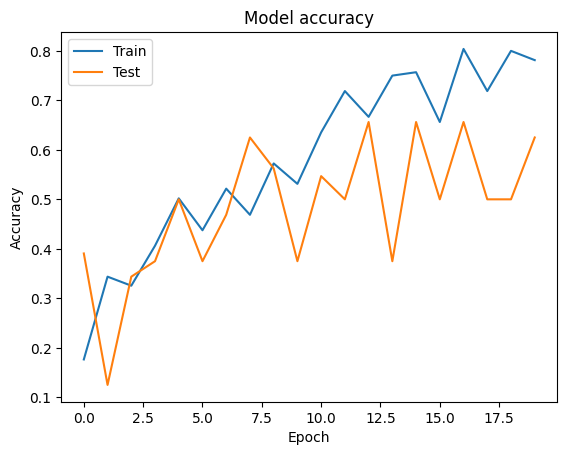

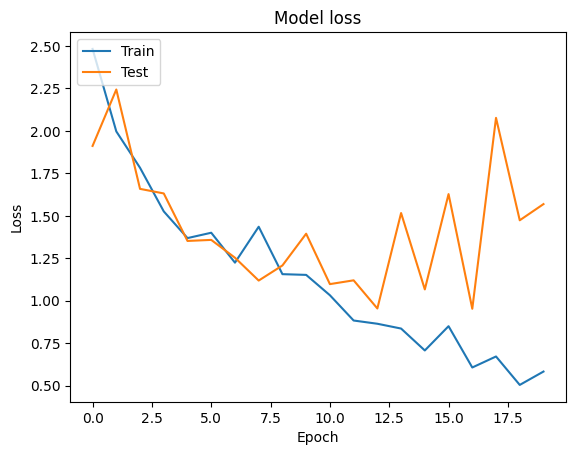

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# AlexNet Model

In [ ]:
alexnet_model = models.Sequential()

alexnet_model.add(layers.Conv2D(96, (11, 11), strides=4, activation='relu',  input_shape=(224, 224, 3)))
alexnet_model.add(layers.MaxPooling2D((3, 3), strides=2))

alexnet_model.add(layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
alexnet_model.add(layers.MaxPooling2D((3, 3), strides=2))

alexnet_model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))
alexnet_model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))
alexnet_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
alexnet_model.add(layers.MaxPooling2D((2, 2), strides=2))

alexnet_model.add(layers.Flatten())
alexnet_model.add(layers.Dense(4096, activation='relu'))
alexnet_model.add(layers.Dropout(0.5))
alexnet_model.add(layers.Dense(4096, activation='relu'))
alexnet_model.add(layers.Dropout(0.5))
alexnet_model.add(layers.Dense(9, activation='softmax'))

alexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = alexnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 856ms/step - accuracy: 0.1085 - loss: 3.6096 - val_accuracy: 0.0938 - val_loss: 2.2009
Epoch 2/20
1/8 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.0323 - loss: 2.2128

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.0323 - loss: 2.2128 - val_accuracy: 0.2500 - val_loss: 2.1997
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 430ms/step - accuracy: 0.0763 - loss: 2.1978 - val_accuracy: 0.0938 - val_loss: 2.1977
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.0938 - loss: 2.1936 - val_accuracy: 0.2500 - val_loss: 2.1899
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - accuracy: 0.0886 - loss: 2.1958 - val_accuracy: 0.1250 - val_loss: 2.0905
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2188 - loss: 2.0913 - val_accuracy: 0.0000e+00 - val_loss: 2.2803
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 496ms/step - accuracy: 0.1212 - loss: 2.0970 - val_accuracy: 0.2188 - val_loss: 1.9059
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.1935 - loss: 2.0428 - val_accuracy: 0.3750 - val_loss: 2.3416
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 539ms/step - accuracy: 0.2303 - loss: 1.9985 - val_accuracy: 0.2031 - val_loss: 2.025

In [ ]:
alexnet_model.evaluate(test_generator)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 767ms/step - accuracy: 0.2817 - loss: 1.7008


[1.6943596601486206, 0.3055555522441864]

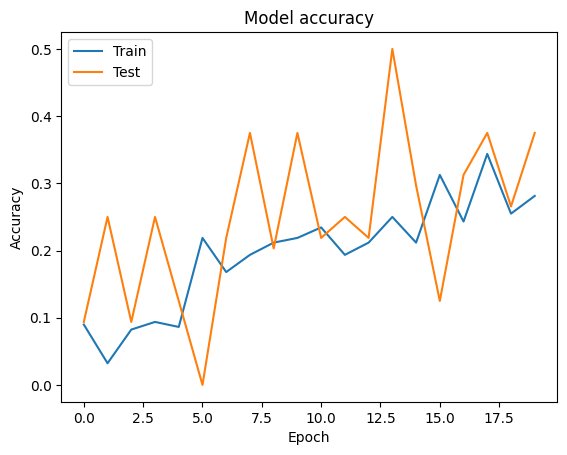

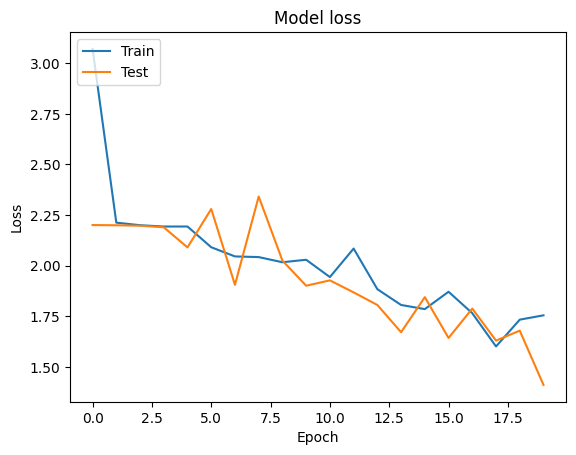

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# ResNet Model

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

resnet_model = models.Sequential([
    resnet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')
])

resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.4036 - loss: 0.4520 - val_accuracy: 0.0938 - val_loss: 4.8965
Epoch 2/20
1/8 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - accuracy: 0.7812 - loss: 0.2562

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.7812 - loss: 0.2562 - val_accuracy: 0.2500 - val_loss: 6.6206
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 697ms/step - accuracy: 0.8200 - loss: 0.1447 - val_accuracy: 0.0938 - val_loss: 0.9374
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8750 - loss: 0.1026 - val_accuracy: 0.2500 - val_loss: 0.5122
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 774ms/step - accuracy: 0.7911 - loss: 0.1208 - val_accuracy: 0.0938 - val_loss: 10.2129
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7812 - loss: 0.1151 - val_accuracy: 0.2500 - val_loss: 55.3410
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 745ms/step - accuracy: 0.7756 - loss: 0.1610 - val_accuracy: 0.1250 - val_loss: 3.4275
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.9062 - loss: 0.0566 - val_accuracy: 0.0000e+00 - val_loss: 3.6083
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 702ms/step - accuracy: 0.8691 - loss: 0.0784 - val_accuracy: 0.1250 - val_loss: 1.72

In [ ]:
resnet_model.evaluate(test_generator)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 747ms/step - accuracy: 0.1024 - loss: 17.3269


[17.447458267211914, 0.1111111119389534]

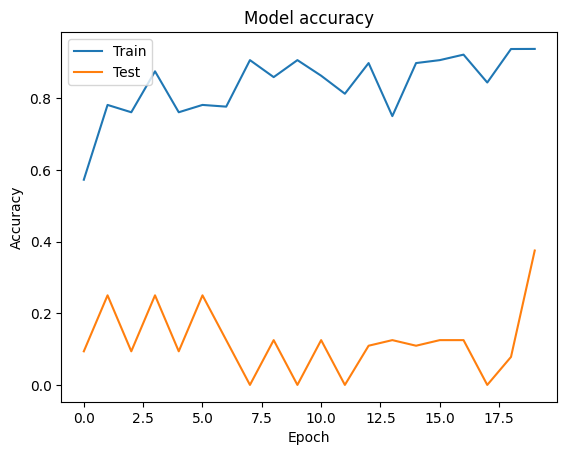

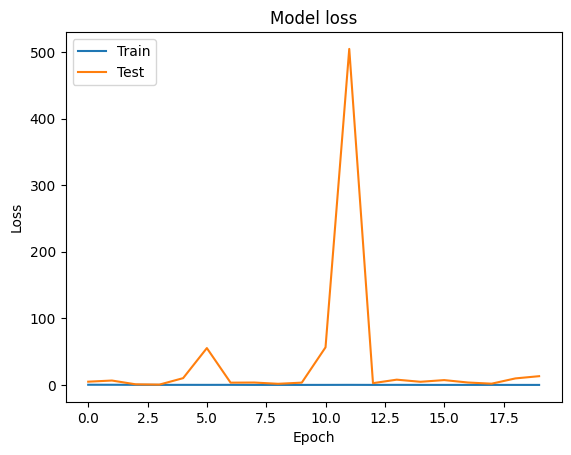

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# VGG16 Model

In [ ]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_base.layers:
    layer.trainable = False

vgg_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
vgg_model = models.Sequential()

vgg_model.add(vgg_base)

vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dense(256, activation='relu'))
vgg_model.add(layers.Dropout(0.5))
vgg_model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

vgg_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
history = vgg_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 934ms/step - accuracy: 0.1380 - loss: 2.5660 - val_accuracy: 0.5781 - val_loss: 1.6859
Epoch 2/20
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.3125 - loss: 2.0191

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.3125 - loss: 2.0191 - val_accuracy: 0.2500 - val_loss: 1.8763
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 484ms/step - accuracy: 0.4612 - loss: 1.5801 - val_accuracy: 0.6562 - val_loss: 1.3324
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4375 - loss: 1.5149 - val_accuracy: 0.8750 - val_loss: 1.1098
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 536ms/step - accuracy: 0.6342 - loss: 1.1807 - val_accuracy: 0.6562 - val_loss: 1.1238
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4062 - loss: 1.3943 - val_accuracy: 0.7500 - val_loss: 0.7738
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 567ms/step - accuracy: 0.6296 - loss: 1.0702 - val_accuracy: 0.7656 - val_loss: 0.8124
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7097 - loss: 1.0506 - val_accuracy: 0.7500 - val_loss: 1.4487
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 568ms/step - accuracy: 0.7548 - loss: 0.7455 - val_accuracy: 0.7812 - val_loss: 0.8260
Epoc

In [ ]:
vgg_model.evaluate(test_generator)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 905ms/step - accuracy: 0.7934 - loss: 0.7019


[0.6590179204940796, 0.8055555820465088]

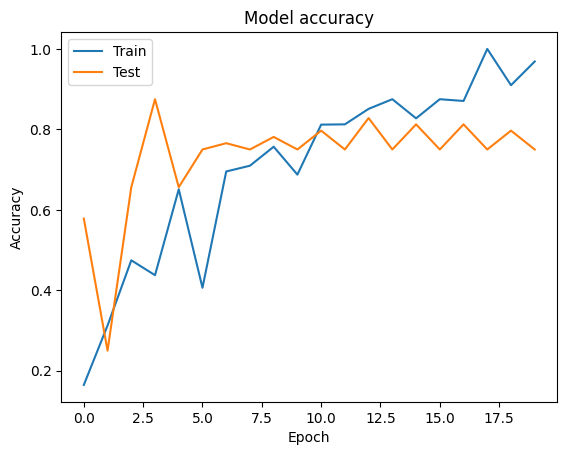

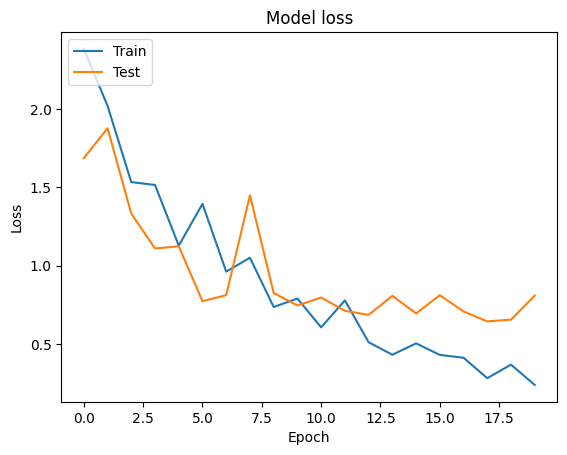

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Champion Model: VGG16

In [ ]:
model = models.Sequential()
model.add(vgg_base)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.1071 - loss: 2.5627 - val_accuracy: 0.4219 - val_loss: 1.6547
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.4375 - loss: 1.7108 - val_accuracy: 0.8750 - val_loss: 1.3618
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 668ms/step - accuracy: 0.4640 - loss: 1.6748 - val_accuracy: 0.6406 - val_loss: 1.3021
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3750 - loss: 1.5673 - val_accuracy: 0.8750 - val_loss: 1.1322
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 547ms/step - accuracy: 0.5869 - loss: 1.2110 - val_accuracy: 0.7344 - val_loss: 1.0221
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6875 - loss: 1.1774 - val_accuracy: 0.8750 - val_loss: 1.0790
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 546ms/step - accuracy: 0.7105 - loss: 0.9310 - val_accuracy: 0.7812 - val_loss: 0.9088
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8125 - loss: 0.7140 - val_accuracy: 0.7500 - val_loss: 0.8

# Champion Model and Summary

In [ ]:
model.evaluate(test_generator)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step - accuracy: 0.8268 - loss: 0.6339


[0.6222792863845825, 0.8333333134651184]

In [ ]:
model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,989,981 (129.66 MB)

 Trainable params: 6,425,097 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 12,850,196 (49.02 MB)